In [1]:
import numpy as np
from utils.models import pytorch_nn
from utils.tools import gen_Xgrid
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import torch
sns.set_theme()
seed = 1853219
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv("data/slip_data.csv")
scaler = StandardScaler()
X, y = df[["f2", "f2ang"]].to_numpy().reshape((-1,2)), df["slips"].to_numpy().reshape((-1,1))
X_scaled = scaler.fit_transform(X)

### Using a Neural Net for Prediction

In [3]:
model = pytorch_nn(hidden_layers=3, hidden_nodes=4, input_dimension=X.shape[1], activation_function = nn.Tanh(), softmax=False)
model.train_model(x = X_scaled, y = y, epochs = 1200, loss_function=nn.MSELoss())

Epoch [10/1200], Loss: 0.024403156712651253
Epoch [20/1200], Loss: 0.021452397108078003
Epoch [30/1200], Loss: 0.3681865334510803
Epoch [40/1200], Loss: 0.027699250727891922
Epoch [50/1200], Loss: 0.09384553879499435
Epoch [60/1200], Loss: 0.028415890410542488
Epoch [70/1200], Loss: 0.0989207848906517
Epoch [80/1200], Loss: 0.016169561073184013
Epoch [90/1200], Loss: 0.08182138949632645
Epoch [100/1200], Loss: 0.03983791172504425
Epoch [110/1200], Loss: 0.01621883735060692
Epoch [120/1200], Loss: 0.016228042542934418
Epoch [130/1200], Loss: 0.023809541016817093
Epoch [140/1200], Loss: 0.038421209901571274
Epoch [150/1200], Loss: 0.033947814255952835
Epoch [160/1200], Loss: 0.03638279065489769
Epoch [170/1200], Loss: 0.027984336018562317
Epoch [180/1200], Loss: 0.02722778357565403
Epoch [190/1200], Loss: 0.029777204617857933
Epoch [200/1200], Loss: 0.03884340822696686
Epoch [210/1200], Loss: 0.01743241399526596
Epoch [220/1200], Loss: 0.029577897861599922
Epoch [230/1200], Loss: 0.05612

Text(0, 0.5, 'f2ang')

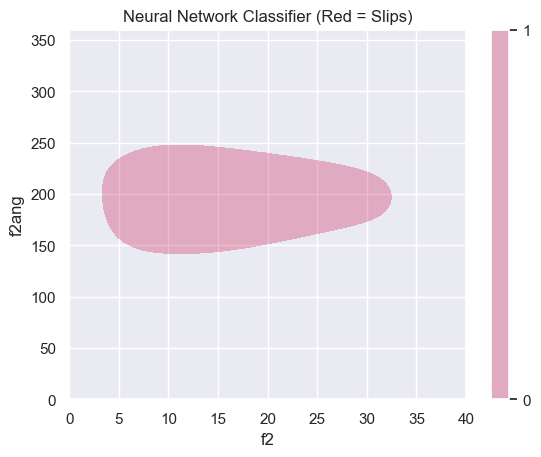

In [4]:
Xgrid, x1, x2 = gen_Xgrid(nx = 2000, ny = 2000, xrange = (0,40), yrange = (0,360))
scaler = StandardScaler()
Xgrid_scaled = scaler.fit_transform(Xgrid)
y_pred = model.predict(Xgrid_scaled)
y_pred[y_pred< 0.5] = 0
y_pred[y_pred>= 0.5] = 1
fig, ax = plt.subplots()
levels = [0,0.999999]
contour = ax.contourf(x1,x2, y_pred.reshape((2000,2000)), levels = levels, alpha = 0.3)
y = y.reshape(-1)
# sns.scatterplot(x = X[y==0, 0], y = X[y == 0, 1], ax = ax)
# sns.scatterplot(x = X[y==1, 0], y = X[y == 1, 1], ax = ax)
fig.colorbar(contour)
ax.set_title("Neural Network Classifier (Red = Slips)")
ax.set_xlabel("f2"); ax.set_ylabel("f2ang")

### Using Physics for Prediction

Net resultant force  >=0 for slip:

fnet = sqrt ((f1,x+f2,x)^2+ (f1,y+f2,y)^2) - μmg

Text(0, 0.5, 'f2ang')

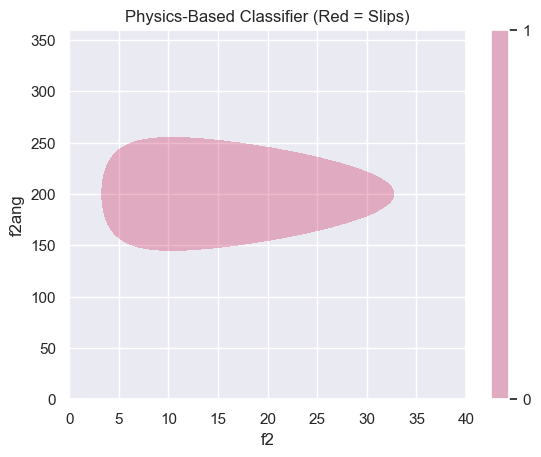

In [5]:
f1 = 18
theta1 = np.deg2rad(20)
f2 = Xgrid[:,0]
theta2 = np.deg2rad(Xgrid[:,1])
G = f2*np.sin(theta2)
mu = 0.5
m = 3
fnet = np.sqrt((f1*np.sin(theta1) + f2*np.sin(theta2))**2 + (f1*np.cos(theta1) + f2*np.cos(theta2))**2) - mu*m*9.81
z = fnet >= 0
z = z.astype(int).reshape(2000,2000)

fig, ax = plt.subplots()
levels = [0,0.999999]
contour = ax.contourf(x1,x2, z, levels = levels, alpha = 0.3)
fig.colorbar(contour)
ax.set_title("Physics-Based Classifier (Red = Slips)")
ax.set_xlabel("f2"); ax.set_ylabel("f2ang")

### SVM Classifier

In [6]:
df = pd.read_csv("data/slip_data_full.csv")
X, y = df[["f1", "f1ang", "f2", "f2ang"]].to_numpy().reshape((-1,4)), df["slips"].to_numpy().reshape((-1,1))

svm = SVC(C = 1000, gamma = 'scale', kernel = 'rbf')
svm.fit(X,y)

d:\mambaforge\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000)

TypeError: Input z must be 2D, not 1D

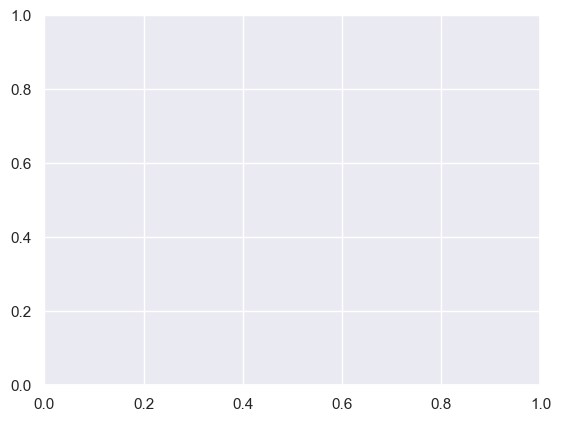

In [7]:
n = Xgrid.shape[0]
f1, theta1 = np.full((n,1), 10), np.full((n,1), 30)
Xgrid = np.hstack((f1,theta1,Xgrid))
y_pred = svm.predict(Xgrid)

Text(0, 0.5, 'f2ang')

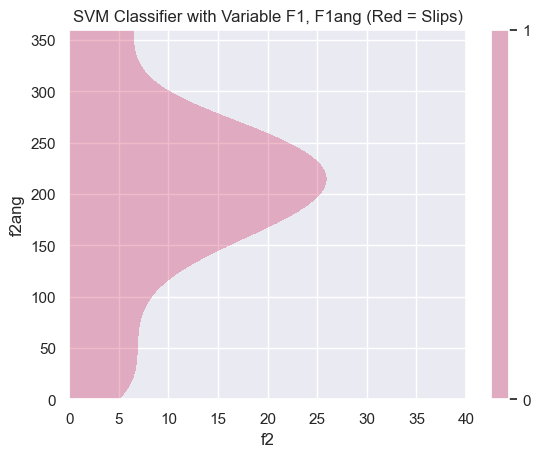

In [8]:
fig, ax = plt.subplots()
levels = [0,0.999999]
contour = ax.contourf(x1,x2, y_pred.reshape((2000,2000)), levels = levels, alpha = 0.3)
fig.colorbar(contour)
ax.set_title("SVM Classifier with Variable F1, F1ang (Red = Slips)")
ax.set_xlabel("f2"); ax.set_ylabel("f2ang")

Text(0, 0.5, 'f2ang')

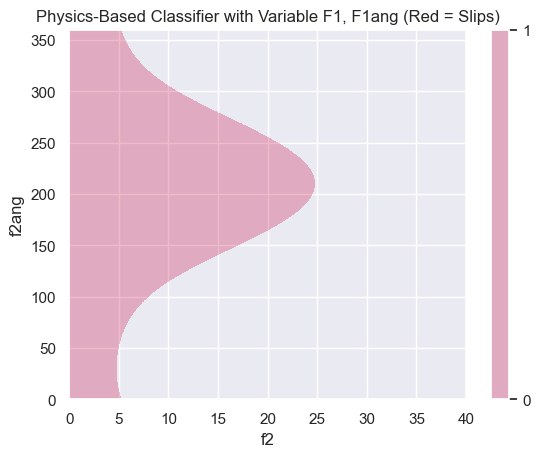

In [10]:
f1 = 10
theta1 = np.deg2rad(30)
f2 = Xgrid[:,2]
theta2 = np.deg2rad(Xgrid[:,3])
G = f2*np.sin(theta2)
mu = 0.5
m = 3
fnet = np.sqrt((f1*np.sin(theta1) + f2*np.sin(theta2))**2 + (f1*np.cos(theta1) + f2*np.cos(theta2))**2) - mu*m*9.81
z = fnet >= 0
z = z.astype(int).reshape(2000,2000)

fig, ax = plt.subplots()
levels = [0,0.999999]
contour = ax.contourf(x1,x2, z, levels = levels, alpha = 0.3)
fig.colorbar(contour)
ax.set_title("Physics-Based Classifier with Variable F1, F1ang (Red = Slips)")
ax.set_xlabel("f2"); ax.set_ylabel("f2ang")